Install Libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from collections import Counter
import random
from datasets import load_dataset
from datasets import load_from_disk
from datasets import concatenate_datasets


Load and filter datasests from huggingface wikiart (dataset of 80k+ pre-labeled artorks) https://huggingface.co/datasets/huggan/wikiart

In [2]:
print("loading dataset")
if not os.path.exists("wikiart"):
    dataset = load_dataset("huggan/wikiart", split="train")
    dataset.save_to_disk("wikiart")
    print("dataset loaded", len(dataset), "images")
    dataset.save_to_disk("wikiart_full_dataset")
    print("dataset saved to disk")
else:
    dataset = load_from_disk("wikiart")
    print("dataset loaded from disk", len(dataset), "images")

loading dataset


Loading dataset from disk:   0%|          | 0/68 [00:00<?, ?it/s]

dataset loaded from disk 81444 images


Keep only Cubism and Impressionism

In [3]:
style_names = dataset.features['style'].names

In [4]:
cubism_index = style_names.index("Cubism")
impressionism_index = style_names.index("Impressionism")
cubism_index, impressionism_index

(7, 12)

In [5]:
target_labels = [cubism_index, impressionism_index]


In [6]:
subset = dataset.filter(
    lambda batch: [style in target_labels for style in batch["style"]],
    batched=True,
    num_proc=4
)


In [7]:
len(subset), "images of Cubism or Impressionism"

(15295, 'images of Cubism or Impressionism')

Map to make classification easier

In [8]:
label_map = {cubism_index: 0, impressionism_index: 1}
labeled_subset = subset.map(lambda x: {"label": label_map[x['style']]})

Now I don't want any low quality images so i am going to check that they originally were big

In [9]:
def is_large(img):
    return img.size[0] >= 1000 and img.size[1] >= 1000
filtered = []
for i in range(len(labeled_subset)):
    if i % 1000 == 0:
        print(i , "/", len(labeled_subset))
    img = labeled_subset[i]['image']
    if is_large(img):
        filtered.append(i)

hq_subset = labeled_subset.select(filtered)


0 / 15295
1000 / 15295
2000 / 15295
3000 / 15295
4000 / 15295
5000 / 15295
6000 / 15295
7000 / 15295
8000 / 15295
9000 / 15295
10000 / 15295
11000 / 15295
12000 / 15295
13000 / 15295
14000 / 15295
15000 / 15295


Now I want the same amount of impressionism images and cubism images

In [10]:
print("getting indices of cubism and impressionism")
label_to_indices = {0: [], 1: []}
for i, example in enumerate(hq_subset):
    if i % 1000 == 0:
        print(i , "/", len(hq_subset))
    label_to_indices[example["label"]].append(i)
print("cubism", len(label_to_indices[0]), "impressionism", len(label_to_indices[1]))
min_count = min(len(label_to_indices[0]), len(label_to_indices[1]))
print("min count", min_count)
print("sampling from classes")
if min_count == len(label_to_indices[0]):
    print("cubism is the smaller class")
    selected_0 = label_to_indices[0]
    selected_1 = random.sample(label_to_indices[1], min_count)
else:
    print("impressionism is the smaller class")
    selected_0 = random.sample(label_to_indices[0], min_count)
    selected_1 = label_to_indices[1]
print("done finding. now selecting")
cubism = hq_subset.select(selected_0)
impressionism = hq_subset.select(selected_1)
print("done selecting now concatenating")
balanced_subset = concatenate_datasets([cubism, impressionism])


getting indices of cubism and impressionism
0 / 15295
1000 / 15295
2000 / 15295
3000 / 15295
4000 / 15295
5000 / 15295
6000 / 15295
7000 / 15295
8000 / 15295
9000 / 15295
10000 / 15295
11000 / 15295
12000 / 15295
13000 / 15295
14000 / 15295
15000 / 15295
cubism 2235 impressionism 13060
min count 2235
sampling from classes
cubism is the smaller class
done finding. now selecting
done selecting now concatenating


In [11]:
# check that there are the same number of images for each class
counts = Counter(balanced_subset["label"])
print("Counts of each class:", counts)


Counts of each class: Counter({0: 2235, 1: 2235})


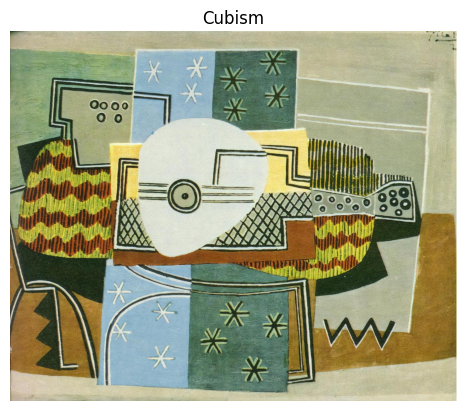

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1669x1382 at 0x105384180>, 'artist': 15, 'genre': 9, 'style': 7, 'label': 0}


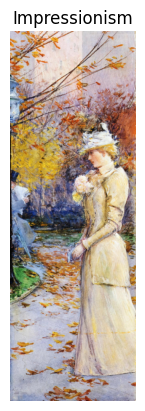

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1382x4064 at 0x13F9C8770>, 'artist': 3, 'genre': 2, 'style': 12, 'label': 1}


In [12]:
# display an example row  (with everything in it) and their correspinding image from each class
def show_example(row):
    img = row["image"]
    style = row["style"]
    style = style_names[style]
    plt.imshow(img)
    plt.title(style)
    plt.axis("off")
    plt.show()
example_cubism = balanced_subset[0]
show_example(example_cubism)
print(example_cubism)
example_impressionism = balanced_subset[-1]
show_example(example_impressionism)
print(example_impressionism)



In [13]:
# tell me all the artists in each of the two label classes
cubism_artists = set()
impressionism_artists = set()
for i in range(len(balanced_subset)):
    if i % 1000 == 0:
        print(i , "/", len(balanced_subset))
    row = balanced_subset[i]
    if row["label"] == 0:
        cubism_artists.add(row["artist"])
    else:
        impressionism_artists.add(row["artist"])
artist_names = dataset.features['artist'].names
cubism_artist_names = [artist_names[artist] for artist in cubism_artists]
impressionism_artist_names = [artist_names[artist] for artist in impressionism_artists]
print("cubism artists", cubism_artist_names)
print("impressionism artists", impressionism_artist_names)


0 / 4470
1000 / 4470
2000 / 4470
3000 / 4470
4000 / 4470
cubism artists ['Unknown Artist', 'ernst-ludwig-kirchner', 'henri-matisse', 'marc-chagall', 'pablo-picasso', 'paul-cezanne', 'pyotr-konchalovsky', 'raoul-dufy', 'salvador-dali', 'm.c.-escher', 'georges-braque', 'juan-gris', 'fernand-leger']
impressionism artists ['Unknown Artist', 'boris-kustodiev', 'camille-pissarro', 'childe-hassam', 'claude-monet', 'edgar-degas', 'eugene-boudin', 'ilya-repin', 'john-singer-sargent', 'pablo-picasso', 'paul-cezanne', 'pierre-auguste-renoir', 'pyotr-konchalovsky', 'salvador-dali', 'paul-gauguin', 'konstantin-makovsky', 'egon-schiele', 'thomas-eakins', 'edvard-munch', 'henri-matisse', 'maxime-maufra', 'alfred-sisley', 'mary-cassatt', 'zinaida-serebriakova', 'georges-seurat', 'isaac-levitan', 'joaquã\xadn-sorolla', 'jacek-malczewski', 'berthe-morisot', 'arkhip-kuindzhi', 'james-tissot', 'valentin-serov', 'ferdinand-hodler', 'giovanni-boldini', 'henri-martin', 'odilon-redon', 'john-henry-twachtman',

In [14]:
# add the artist name to the dataset
artist_names = dataset.features['artist'].names
def add_artist_name(example):
    artist = example["artist"]
    artist_name = artist_names[artist]
    return {"artist_name": artist_name}
balanced_subset = balanced_subset.map(add_artist_name)


Map:   0%|          | 0/4470 [00:00<?, ? examples/s]

In [15]:
# add the genre name to the dataset
genre_names = dataset.features['genre'].names
def add_genre_name(example):
    genre = example["genre"]
    genre_name = genre_names[genre]
    return {"genre_name": genre_name}
balanced_subset = balanced_subset.map(add_genre_name)


Map:   0%|          | 0/4470 [00:00<?, ? examples/s]

In [16]:
style_names = dataset.features['style'].names
def add_genre_name(example):
    genre = example["style"]
    style_name = style_names[genre]
    return {"style_name": style_name}
balanced_subset = balanced_subset.map(add_genre_name)

Map:   0%|          | 0/4470 [00:00<?, ? examples/s]

In [17]:
balanced_subset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1669x1382>,
 'artist': 15,
 'genre': 9,
 'style': 7,
 'label': 0,
 'artist_name': 'pablo-picasso',
 'genre_name': 'still_life',
 'style_name': 'Cubism'}

Because CNNs expect something to be 224x224

In [18]:
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
])
def compress_batch(batch):
    return {
        "image_compressed": [resize_transform(img) for img in batch["image"]]
    }

preprocessed = balanced_subset.map(
    compress_batch,
    batched=True,
    batch_size=16,    
    num_proc=1         
)


Map:   0%|          | 0/4470 [00:00<?, ? examples/s]

In [19]:
# now save the preprocessed dataset to disk
preprocessed.save_to_disk("wikiart_preprocessed")
print("preprocessed dataset saved to disk")

Saving the dataset (0/5 shards):   0%|          | 0/4470 [00:00<?, ? examples/s]

preprocessed dataset saved to disk


Now time to explore

In [20]:
# tell me information about the dataset
print("dataset size", len(preprocessed))
print("cubism/impressionism size", len(preprocessed)/2)
print("cubism artists", len(cubism_artists))
print("impressionism artists", len(impressionism_artists))
# what artist are both cubist and impressionist
cubism_artists = set(cubism_artist_names)
impressionism_artists = set(impressionism_artist_names)
both_artists = cubism_artists.intersection(impressionism_artists)
print("artists that are both cubist and impressionist", both_artists)
# what artists are most common in each class
cubism_artist_counts = Counter(balanced_subset.filter(lambda x: x["label"] == 0)["artist_name"])
impressionism_artist_counts = Counter(balanced_subset.filter(lambda x: x["label"] == 1)["artist_name"])
print("cubism artist counts", cubism_artist_counts.most_common(10))
print("impressionism artist counts", impressionism_artist_counts.most_common(10))
# what genres are most common in each class
cubism_genre_counts = Counter(balanced_subset.filter(lambda x: x["label"] == 0)["genre_name"])
impressionism_genre_counts = Counter(balanced_subset.filter(lambda x: x["label"] == 1)["genre_name"])
print("cubism genre counts", cubism_genre_counts.most_common(10))
print("impressionism genre counts", impressionism_genre_counts.most_common(10))
# what styles are most common in each class
cubism_style_counts = Counter(balanced_subset.filter(lambda x: x["label"] == 0)["style_name"])
impressionism_style_counts = Counter(balanced_subset.filter(lambda x: x["label"] == 1)["style_name"])
print("cubism style counts", cubism_style_counts.most_common(10))
print("impressionism style counts", impressionism_style_counts.most_common(10))

dataset size 4470
cubism/impressionism size 2235.0
cubism artists 13
impressionism artists 50
artists that are both cubist and impressionist {'pablo-picasso', 'salvador-dali', 'paul-cezanne', 'raoul-dufy', 'henri-matisse', 'pyotr-konchalovsky', 'Unknown Artist'}


Filter:   0%|          | 0/4470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4470 [00:00<?, ? examples/s]

cubism artist counts [('Unknown Artist', 1457), ('pablo-picasso', 203), ('fernand-leger', 121), ('pyotr-konchalovsky', 88), ('georges-braque', 75), ('juan-gris', 71), ('marc-chagall', 67), ('paul-cezanne', 56), ('salvador-dali', 41), ('ernst-ludwig-kirchner', 23)]
impressionism artist counts [('Unknown Artist', 656), ('claude-monet', 222), ('pierre-auguste-renoir', 221), ('camille-pissarro', 134), ('edgar-degas', 111), ('eugene-boudin', 101), ('alfred-sisley', 90), ('childe-hassam', 80), ('john-singer-sargent', 61), ('joaquã\xadn-sorolla', 50)]


Filter:   0%|          | 0/4470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4470 [00:00<?, ? examples/s]

cubism genre counts [('Unknown Genre', 492), ('still_life', 420), ('portrait', 323), ('genre_painting', 289), ('landscape', 203), ('cityscape', 144), ('abstract_painting', 128), ('nude_painting', 127), ('sketch_and_study', 84), ('religious_painting', 20)]
impressionism genre counts [('landscape', 687), ('genre_painting', 472), ('portrait', 327), ('Unknown Genre', 283), ('cityscape', 279), ('still_life', 80), ('nude_painting', 53), ('sketch_and_study', 51), ('religious_painting', 3)]
cubism style counts [('Cubism', 2235)]
impressionism style counts [('Impressionism', 2235)]


In [21]:
from datasets import load_from_disk

final_dataset = load_from_disk("wikiart_preprocessed")

In [22]:
cubism = final_dataset.select(range(2235))
impressionism = final_dataset.select(range(2235, len(final_dataset)))

In [ ]:
cubism_images = cubism["image_compressed"]
impressionism_images = impressionism["image_compressed"]

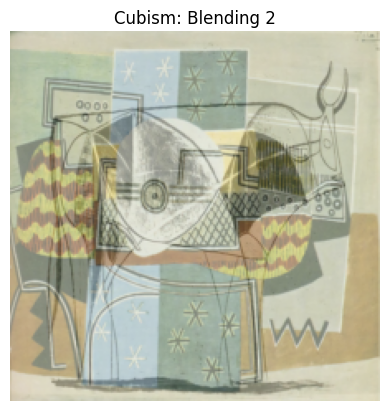

In [37]:
cubism_image_1 = np.array(cubism_images[0]) / 255.0
cubism_image_2 = np.array(cubism_images[1]) / 255.0
average_image = np.mean([cubism_image_1, cubism_image_2], axis=0)
average_image = (average_image * 255).astype(np.uint8)
plt.imshow(average_image)
plt.axis("off")
plt.title("Cubism: Blending 2")
plt.show()

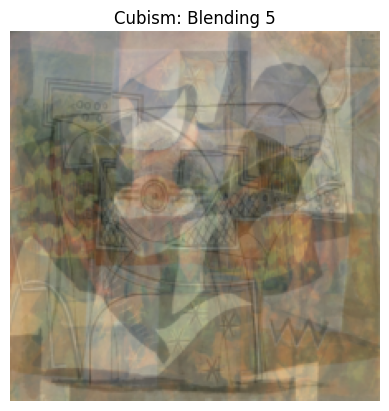

In [38]:
average_image = np.mean([np.array(cubism_images[0]) / 255.0, np.array(cubism_images[1]) / 255.0, np.array(cubism_images[2]) / 255.0, np.array(cubism_images[3]) / 255.0, np.array(cubism_images[4]) / 255.0], axis=0)
average_image = (average_image * 255).astype(np.uint8)
plt.imshow(average_image)
plt.axis("off")
plt.title("Cubism: Blending 5")
plt.show()

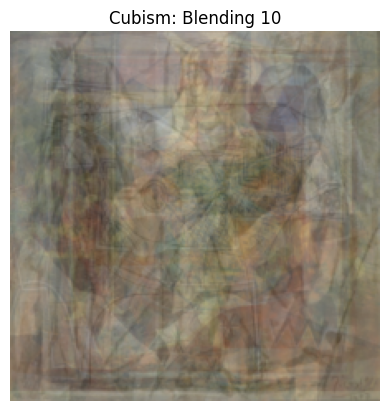

In [39]:
average_image = np.mean([np.array(cubism_images[0]) / 255.0, np.array(cubism_images[1]) / 255.0, np.array(cubism_images[2]) / 255.0, np.array(cubism_images[3]) / 255.0, np.array(cubism_images[4]) / 255.0, np.array(cubism_images[5]) / 255.0, np.array(cubism_images[6]) / 255.0, np.array(cubism_images[7]) / 255.0, np.array(cubism_images[8]) / 255.0, np.array(cubism_images[9]) / 255.0], axis=0)
average_image = (average_image * 255).astype(np.uint8)
plt.imshow(average_image)
plt.axis("off")
plt.title("Cubism: Blending 10")
plt.show()

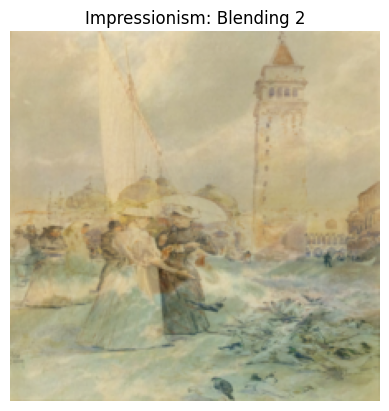

In [40]:
average_image = np.mean([np.array(impressionism_images[0]) / 255.0, np.array(impressionism_images[1]) / 255.0], axis=0)
average_image = (average_image * 255).astype(np.uint8)
plt.imshow(average_image)
plt.axis("off")
plt.title("Impressionism: Blending 2")
plt.show()

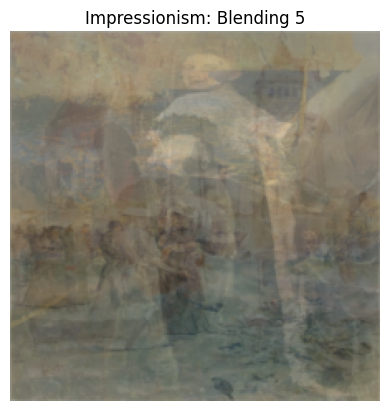

In [41]:
average_image = np.mean([np.array(impressionism_images[0]) / 255.0, np.array(impressionism_images[1]) / 255.0, np.array(impressionism_images[2]) / 255.0, np.array(impressionism_images[3]) / 255.0, np.array(impressionism_images[4]) / 255.0], axis=0)
average_image = (average_image * 255).astype(np.uint8)
plt.imshow(average_image)
plt.axis("off")
plt.title("Impressionism: Blending 5")
plt.show()

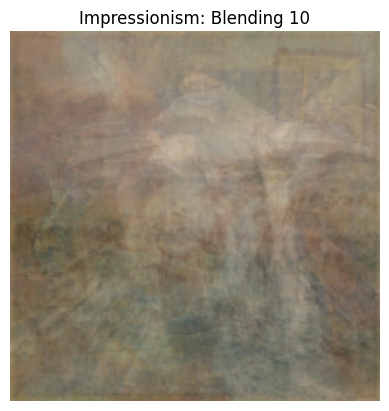

In [42]:
average_image = np.mean([np.array(impressionism_images[0]) / 255.0, np.array(impressionism_images[1]) / 255.0, np.array(impressionism_images[2]) / 255.0, np.array(impressionism_images[3]) / 255.0, np.array(impressionism_images[4]) / 255.0, np.array(impressionism_images[5]) / 255.0, np.array(impressionism_images[6]) / 255.0, np.array(impressionism_images[7]) / 255.0, np.array(impressionism_images[8]) / 255.0, np.array(impressionism_images[9]) / 255.0], axis=0)
average_image = (average_image * 255).astype(np.uint8)
plt.imshow(average_image)
plt.axis("off")
plt.title("Impressionism: Blending 10")
plt.show()

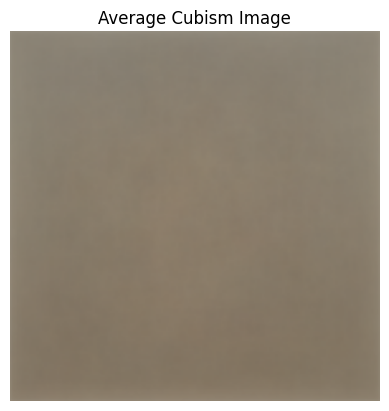

In [25]:

normalized_cubism_images = [np.array(img) / 255.0 for img in cubism_images]
average_cubism_image = np.mean(normalized_cubism_images, axis=0)
average_cubism_image = (average_cubism_image * 255).astype(np.uint8)
plt.imshow(average_cubism_image)
plt.axis("off")
plt.title("Average Cubism Image")
plt.show()

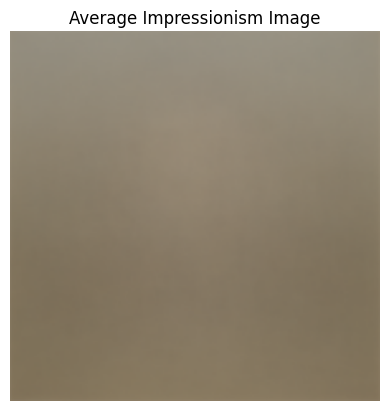

In [26]:
normalized_impressionism_images = [np.array(img) / 255.0 for img in impressionism_images]
average_impressionism_image = np.mean(normalized_impressionism_images, axis=0)
average_impressionism_image = (average_impressionism_image * 255).astype(np.uint8)
plt.imshow(average_impressionism_image)
plt.axis("off")
plt.title("Average Impressionism Image")
plt.show()